1. Dependencies and Imports

In [2]:
# !pip install torch torchvision opacus

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from opacus import PrivacyEngine
import matplotlib.pyplot as plt


/home/cyber1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Data Preparation

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)


3. Model Definition

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        # Dynamically determine the size
        sample_input = torch.zeros(1, 1, 28, 28)
        sample_output = self.features(sample_input)
        num_features = sample_output.shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


4. Define Training and Testing

In [6]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    for epoch in range(1, 6):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

def test(model, test_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

5. Run Standard Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_standard = SimpleCNN().to(device)
optimizer_standard = optim.Adam(model_standard.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

print("Training standard model...")
train(model_standard, train_loader, optimizer_standard, criterion, device)
accuracy_standard = test(model_standard, test_loader, device)
print(f"Standard Model Accuracy: {accuracy_standard:.2f}%")


Training standard model...
Epoch 1, Loss: 0.1277
Epoch 2, Loss: 0.0367
Epoch 3, Loss: 0.0215
Epoch 4, Loss: 0.0134
Epoch 5, Loss: 0.0106
Standard Model Accuracy: 98.86%


6. Run Differential Privacy Training

In [ ]:
model_dp = SimpleCNN().to(device)
optimizer_dp = optim.Adam(model_dp.parameters(), lr=1e-4)
privacy_engine = PrivacyEngine()

model_dp, optimizer_dp, train_loader_dp = privacy_engine.make_private(
    module=model_dp,
    optimizer=optimizer_dp,
    data_loader=train_loader,
    noise_multiplier=1.1,  # Higher noise = more privacy
    max_grad_norm=1.0,
)

print("Training DP model...")
train(model_dp, train_loader_dp, optimizer_dp, criterion, device)
accuracy_dp = test(model_dp, test_loader, device)
print(f"DP Model Accuracy: {accuracy_dp:.2f}%")
print(f"DP Model is using (ε = {privacy_engine.get_epsilon(1e-4):.2f}, δ = 1e-4)")



Training DP model...
Epoch 1, Loss: 1.7567
Epoch 2, Loss: 0.7727
Epoch 3, Loss: 0.5621
Epoch 4, Loss: 0.5222
Epoch 5, Loss: 0.5113
DP Model Accuracy: 87.85%
DP Model is using (ε = 0.24, δ = 1e-5)


7. Compare the Results

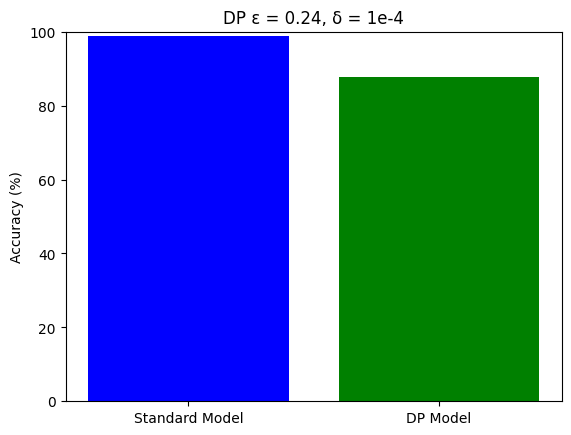

In [14]:
labels = ['Standard Model', 'DP Model']
accuracies = [accuracy_standard, accuracy_dp]
epsilon = privacy_engine.get_epsilon(1e-4)

plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy (%)')
plt.title(f'DP ε = {epsilon:.2f}, δ = 1e-4')
plt.ylim(0, 100)
plt.show()


8. Compare Additional Noises and their effect on test accuracy, generalization gap, and member inference attack success rates

Defaulting to user installation because normal site-packages is not writeable


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1, Loss: 1.3871
Epoch 2, Loss: 0.5355
Epoch 3, Loss: 0.5024
Epoch 4, Loss: 0.5302
Epoch 5, Loss: 0.5335


 25%|██▌       | 1/4 [02:14<06:43, 134.66s/it]

Epoch 1, Loss: 1.6294
Epoch 2, Loss: 0.7083
Epoch 3, Loss: 0.5331
Epoch 4, Loss: 0.5082
Epoch 5, Loss: 0.5019


 50%|█████     | 2/4 [04:29<04:29, 134.75s/it]

Epoch 1, Loss: 2.0751
Epoch 2, Loss: 1.3724
Epoch 3, Loss: 0.8593
Epoch 4, Loss: 0.6622
Epoch 5, Loss: 0.5756


 75%|███████▌  | 3/4 [06:45<02:15, 135.18s/it]

Epoch 1, Loss: 2.2354
Epoch 2, Loss: 2.0623
Epoch 3, Loss: 1.7929
Epoch 4, Loss: 1.4335
Epoch 5, Loss: 1.0960


/home/cyber1/.local/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
100%|██████████| 4/4 [09:00<00:00, 135.04s/it]


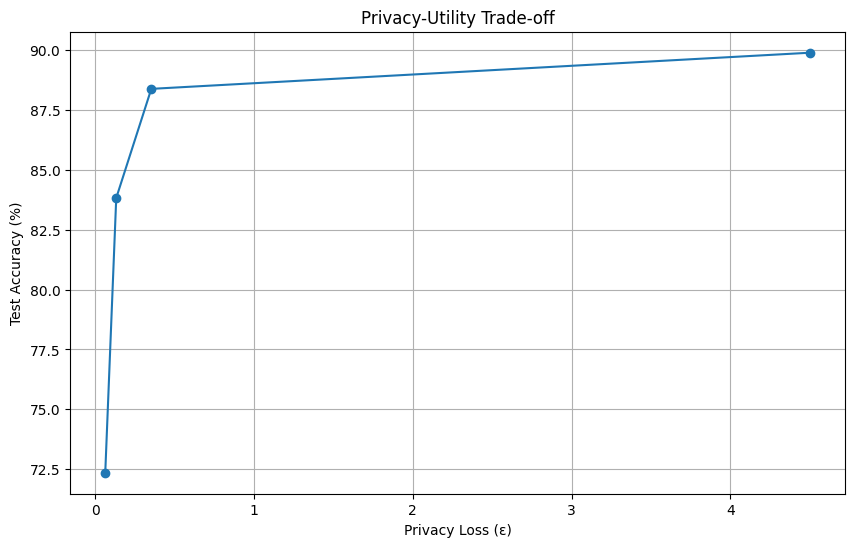

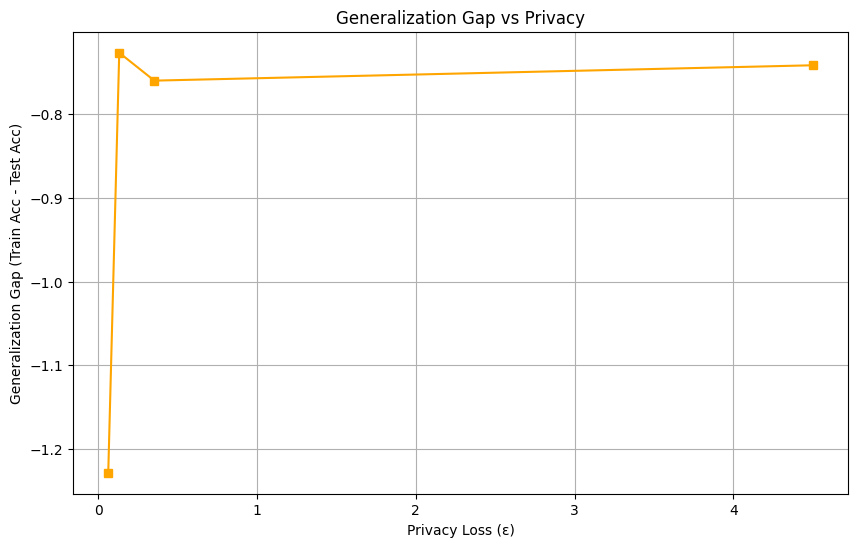

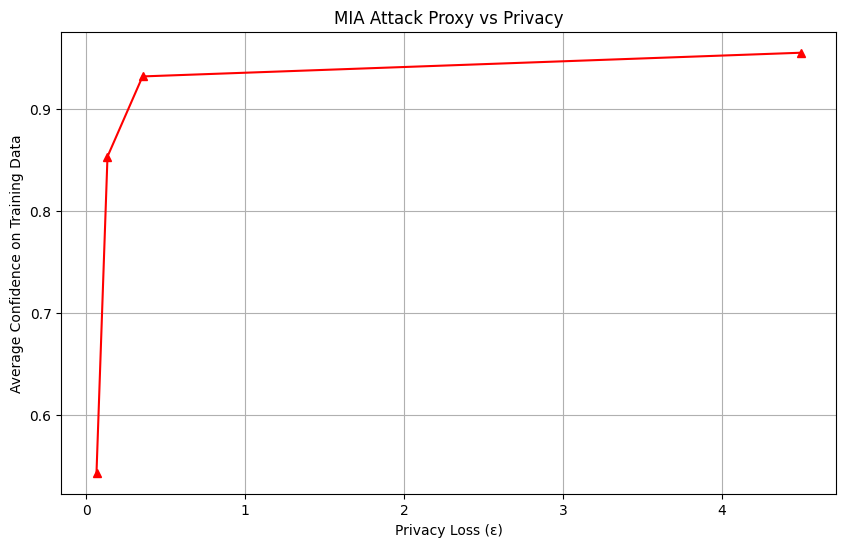

In [8]:
!pip install mia
import matplotlib.pyplot as plt
from opacus import PrivacyEngine
from tqdm import tqdm
import numpy as np

noise_levels = [0.5, 1.0, 2.0, 4.0]
epsilons = []
accuracies = []
mia_attack_success_rates = []
generalization_gaps = []

def basic_mia_attack(model, loader, device):
    model.eval()
    confidences = []
    for data, _ in loader:
        data = data.to(device)
        outputs = model(data)
        confidence = torch.max(torch.softmax(outputs, dim=1), dim=1)[0]
        confidences.extend(confidence.cpu().detach().numpy())
    # Simple heuristic: higher confidence = more likely to be training data
    return np.mean(confidences)

for noise_multiplier in tqdm(noise_levels):
    model_dp = SimpleCNN().to(device)
    optimizer_dp = optim.Adam(model_dp.parameters(), lr=1e-4)

    privacy_engine = PrivacyEngine()
    model_dp, optimizer_dp, train_loader_dp = privacy_engine.make_private(
        module=model_dp,
        optimizer=optimizer_dp,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=1.0,
    )

    # Train DP model (fewer epochs for speed)
    train(model_dp, train_loader_dp, optimizer_dp, criterion, device)

    train_accuracy = test(model_dp, train_loader, device)
    test_accuracy = test(model_dp, test_loader, device)
    epsilon = privacy_engine.get_epsilon(1e-5)

    generalization_gap = train_accuracy - test_accuracy
    mia_score = basic_mia_attack(model_dp, train_loader, device)

    accuracies.append(test_accuracy)
    epsilons.append(epsilon)
    generalization_gaps.append(generalization_gap)
    mia_attack_success_rates.append(mia_score)

# Plot privacy-utility trade-off
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, marker='o')
plt.xlabel("Privacy Loss (ε)")
plt.ylabel("Test Accuracy (%)")
plt.title("Privacy-Utility Trade-off")
plt.grid(True)
plt.show()

# Generalization Gap vs ε
plt.figure(figsize=(10, 6))
plt.plot(epsilons, generalization_gaps, marker='s', color='orange')
plt.xlabel("Privacy Loss (ε)")
plt.ylabel("Generalization Gap (Train Acc - Test Acc)")
plt.title("Generalization Gap vs Privacy")
plt.grid(True)
plt.show()

# MIA Attack Success vs ε
plt.figure(figsize=(10, 6))
plt.plot(epsilons, mia_attack_success_rates, marker='^', color='red')
plt.xlabel("Privacy Loss (ε)")
plt.ylabel("Average Confidence on Training Data")
plt.title("MIA Attack Proxy vs Privacy")
plt.grid(True)
plt.show()

